<a href="https://colab.research.google.com/github/sarabdeen/projects/blob/main/Copy_of_digital_wallet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle_api_credentials/kaggle-2.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json #changes permission to owner only for read/write

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/kaggle_api_credentials/digital_wallet_transactions.csv')
print(df.head())


   idx                        transaction_id     user_id  transaction_date  \
0    1  4dac3ea3-6492-46ec-80b8-dc45c3ad0b14  USER_05159  2023-08-19 03:32   
1    2  a903ed9f-eb84-47e7-b8aa-fd1786c919cf  USER_07204  2023-08-19 04:37   
2    3  2a393013-733c-4add-9f09-bed1eeb33676  USER_00903  2023-08-19 05:52   
3    4  9a07ad19-4673-4794-9cd2-9b139f39c715  USER_01769  2023-08-19 06:35   
4    5  76418260-c985-4011-979d-0914604d0d68  USER_03544  2023-08-19 06:36   

  product_category               product_name     merchant_name  \
0     Rent Payment          2BHK Flat Deposit            Airbnb   
1         Gas Bill  Commercial Gas Connection         Adani Gas   
2       Bus Ticket               Semi-Sleeper    MakeMyTrip Bus   
3    Internet Bill          4G Unlimited Plan  Airtel Broadband   
4   Loan Repayment              Home Loan EMI         Axis Bank   

   product_amount  transaction_fee  cashback  loyalty_points payment_method  \
0         1525.39            36.69     19.19     

In [ ]:
# cleaning: ensuring that datetime is in the correct format

df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')

#rows with invalid datetime values
invalid_dates = df[df['transaction_date'].isnull()]
if not invalid_dates.empty:
    print("invalid row of 'transaction_date' values.")


In [ ]:
# removing duplicates and missing values
df = df.drop_duplicates(subset='transaction_id')
df = df.dropna()

In [ ]:
# establishing high value transactions (500 or above)
df['high_value'] = df['product_amount'] > 500

# analyzing user behavior
user_transaction_summary = df.groupby('user_id').agg({
    'product_amount': ['sum', 'mean', 'count'],
    'high_value': 'sum'
}).reset_index()

user_transaction_summary.columns = ['user_id', 'total_spent', 'avg_transaction', 'num_transactions', 'num_high_value_transactions']

#numerical columns are in the correct format
df = df[df['product_amount'] >= 0]

In [ ]:
#identifying outliers using z-scores and removing extreme outliers
import numpy as np
df['z_score'] = np.abs((df['product_amount'] - df['product_amount'].mean()) / df['product_amount'].std())
df = df[df['z_score'] < 3]
df.drop(columns='z_score', inplace=True)


In [ ]:
# maintaing capitalization consistency
df['product_category'] = df['product_category'].str.lower().str.strip()
df['payment_method'] = df['payment_method'].str.lower().str.strip()

#filtering and only keeping SUCCESSFUL transactions
df = df[df['transaction_status'] == 'Successful']


In [ ]:
#feature engineering: creating day of the week and transaction net amount
df['day_of_week'] = df['transaction_date'].dt.day_name()
df['net_amount'] = df['product_amount'] - df['transaction_fee'] + df['cashback']

In [ ]:
# dropping additonal columns
df = df.drop(columns=['device_type', 'merchant_id', 'location'])

print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 4755 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   idx                 4755 non-null   int64         
 1   transaction_id      4755 non-null   object        
 2   user_id             4755 non-null   object        
 3   transaction_date    4755 non-null   datetime64[ns]
 4   product_category    4755 non-null   object        
 5   product_name        4755 non-null   object        
 6   merchant_name       4755 non-null   object        
 7   product_amount      4755 non-null   float64       
 8   transaction_fee     4755 non-null   float64       
 9   cashback            4755 non-null   float64       
 10  loyalty_points      4755 non-null   int64         
 11  payment_method      4755 non-null   object        
 12  transaction_status  4755 non-null   object        
 13  high_value          4755 non-null   bool          
 1

In [ ]:
print(df.describe())
print(df.head())

               idx               transaction_date  product_amount  \
count  4755.000000                           4755     4755.000000   
mean   2501.360042  2024-02-19 10:57:05.261829632     4954.578111   
min       1.000000            2023-08-19 03:32:00       10.090000   
25%    1251.500000            2023-11-19 16:14:00     2450.965000   
50%    2500.000000            2024-02-20 07:27:00     4944.250000   
75%    3754.500000            2024-05-22 16:18:30     7433.885000   
max    5000.000000            2024-08-18 01:15:00     9996.950000   
std    1445.031164                            NaN     2880.868656   

       transaction_fee     cashback  loyalty_points    net_amount  
count      4755.000000  4755.000000     4755.000000   4755.000000  
mean         25.219914    50.778511      498.706625   4980.136709  
min           0.010000     0.000000        0.000000     -4.920000  
25%          12.715000    26.680000      246.000000   2469.590000  
50%          25.090000    51.550000   

               idx               transaction_date  product_amount  \
count  4755.000000                           4755     4755.000000   
mean   2501.360042  2024-02-19 10:57:05.261829632     4954.578111   
min       1.000000            2023-08-19 03:32:00       10.090000   
25%    1251.500000            2023-11-19 16:14:00     2450.965000   
50%    2500.000000            2024-02-20 07:27:00     4944.250000   
75%    3754.500000            2024-05-22 16:18:30     7433.885000   
max    5000.000000            2024-08-18 01:15:00     9996.950000   
std    1445.031164                            NaN     2880.868656   

       transaction_fee     cashback  loyalty_points    net_amount  
count      4755.000000  4755.000000     4755.000000   4755.000000  
mean         25.219914    50.778511      498.706625   4980.136709  
min           0.010000     0.000000        0.000000     -4.920000  
25%          12.715000    26.680000      246.000000   2469.590000  
50%          25.090000    51.550000   

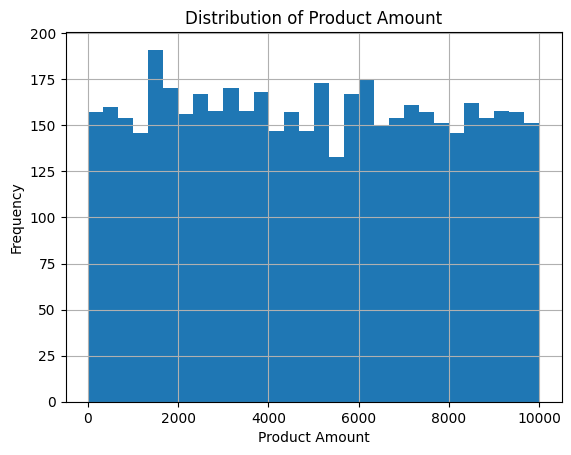

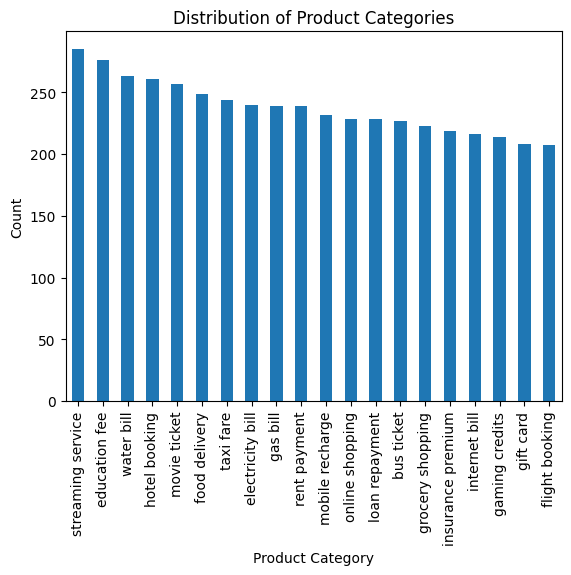

<ipython-input-20-656b089b4290>:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('transaction_date')['product_amount'].resample('M').sum().plot()


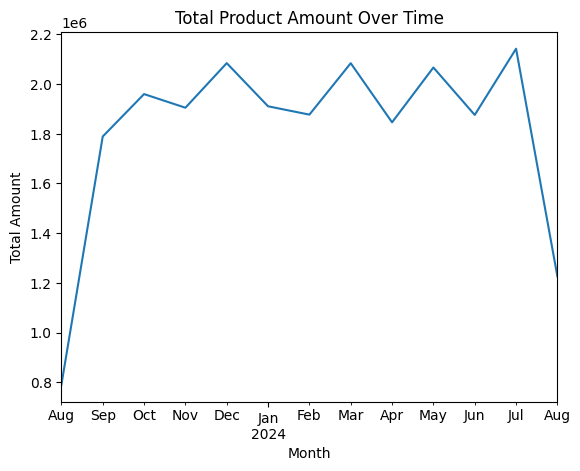

           product_amount          transaction_id
                     mean      sum          count
user_id                                          
USER_00001        5810.65  5810.65              1
USER_00002        1785.23  1785.23              1
USER_00019        2709.49  5418.98              2
USER_00020        3619.00  3619.00              1
USER_00025        8229.46  8229.46              1


In [ ]:
#EXPLORATORY DATA ANALYSIS (EDA)
print(df.describe())

#histogram for product_amount and transaction fee
import matplotlib.pyplot as plt
df['product_amount'].hist(bins=30)
plt.title('Distribution of Product Amount')
plt.xlabel('Product Amount')
plt.ylabel('Frequency')
plt.show()

#categorical cols for product_category and payment_methods
df['product_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.show()


#time analysis
df.set_index('transaction_date')['product_amount'].resample('M').sum().plot()
plt.title('Total Product Amount Over Time')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.show()

#identifying patterns
user_summary = df.groupby('user_id').agg({'product_amount': ['mean', 'sum'], 'transaction_id': 'count'})
print(user_summary.head())


In [ ]:
# feature engineering

#adding month,day, hour, etc
df['transaction_month'] = df['transaction_date'].dt.month
df['transaction_day'] = df['transaction_date'].dt.day
df['transaction_weekday'] = df['transaction_date'].dt.weekday  # 0=Monday, 6=Sunday
df['transaction_hour'] = df['transaction_date'].dt.hour

df['transaction_value_category'] = pd.cut(
    df['product_amount'],
    bins=[0, 500, 1000, float('inf')],
    labels=['Low', 'Medium', 'High']
)

#net amount calculation
df['net_amount'] = df['product_amount'] - df['transaction_fee'] + df['cashback']

#adding user behavior (total spending and average transaction amt)
user_features = df.groupby('user_id').agg({
    'product_amount': ['sum', 'mean', 'count'],
    'net_amount': 'sum'
}).reset_index()
user_features.columns = ['user_id', 'total_spent', 'avg_transaction_amount', 'num_transactions', 'total_net_amount']

#interaction features
df['category_payment_interaction'] = df['product_category'] + '_' + df['payment_method']

#loyalty points
df['loyalty_points_per_dollar'] = df['loyalty_points'] / df['product_amount']
df['loyalty_points_per_dollar'].fillna(0, inplace=True)  # Handle any division by zero


<ipython-input-23-b3f9c8b6a78c>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['loyalty_points_per_dollar'].fillna(0, inplace=True)  # Handle any division by zero


In [ ]:
#making sure there is no errors
print(df.isnull().sum())


idx                             0
transaction_id                  0
user_id                         0
transaction_date                0
product_category                0
product_name                    0
merchant_name                   0
product_amount                  0
transaction_fee                 0
cashback                        0
loyalty_points                  0
payment_method                  0
transaction_status              0
high_value                      0
day_of_week                     0
net_amount                      0
transaction_month               0
transaction_day                 0
transaction_weekday             0
transaction_hour                0
transaction_value_category      0
category_payment_interaction    0
loyalty_points_per_dollar       0
dtype: int64


In [ ]:
#scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['product_amount', 'transaction_fee', 'cashback']] = scaler.fit_transform(df[['product_amount', 'transaction_fee', 'cashback']])


In [ ]:
!pip install scikit-learn


Mean Absolute Error: 1.9526684746773832e-15
R-squared: 1.0
Model Coefficients: [ 1.28203004e-19  5.04247233e-03 -9.90192897e-03  2.43945489e-19
  3.47154032e-04 -1.91090633e-18  1.18923426e-18 -4.37852506e-18
 -3.17764410e-18  1.62736205e-18]
Model Intercept: -1.7288745376385997


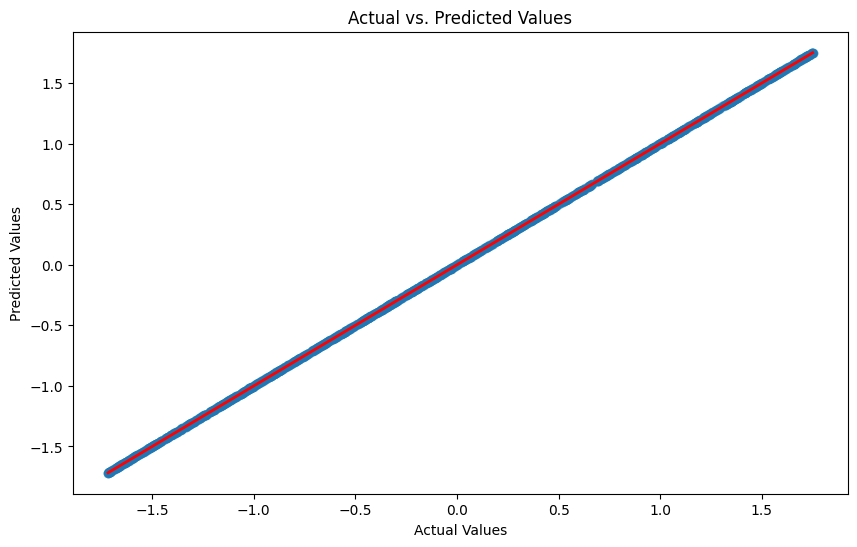

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# split the data into features and target (x and y)
X = df.select_dtypes(include='number').drop(['product_amount'], axis=1)
y = df['product_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train the model
model = LinearRegression()
model.fit(X_train, y_train)

#making predictions
y_pred = model.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('R-squared:', r2_score(y_test, y_pred))


print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.show()

